## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration using Chessboard

In [17]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# visualization will be shown in the notebook
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Define Methods to Undistort Images

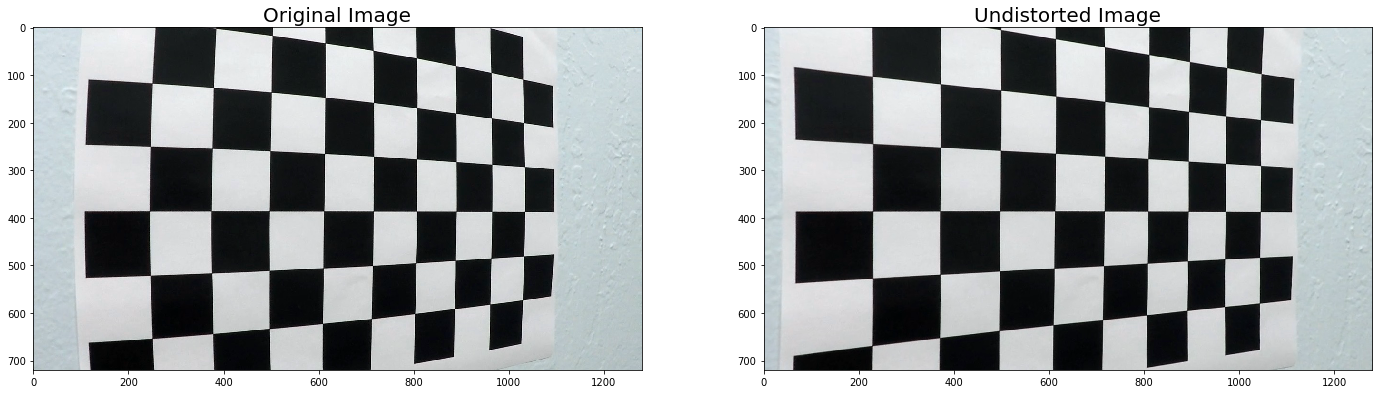

In [19]:
def cal_undistort(img, objpoints, imgpoints):
    # Do camera calibration given object points and image points
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def plot_image_comparison(original, undistorted):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(original)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=20)

# show an example of the undistorted image
img = cv2.imread('../camera_cal/calibration5.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
plot_image_comparison(img, undistorted)

In [20]:
import matplotlib.image as mpimg

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(200, 250), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # H-channel between 20-25 is for yellow hue
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= 20) & (h_channel <= 25)] = 1

    # v-channel high for bright and highly reflective materials
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= 220) & (v_channel <= 255)] = 1

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary = np.dstack((s_binary, v_binary, sxbinary)) * 255
    
    # Combined binary1 (probably most robust, due to having saturation channel)
    combined_binary1 = np.zeros_like(sxbinary)
    combined_binary1[(s_binary == 1) | (v_binary == 1) | (sxbinary == 1)] = 1
    
    # Combined binary2 (probably the most clear in this example)
    combined_binary2 = np.zeros_like(sxbinary)
    combined_binary2[(h_binary == 1) | (v_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary1.astype(np.uint8), combined_binary2.astype(np.uint8)

image = mpimg.imread('test_images/test2.jpg')
result1, result2 = pipeline(image)

plot_image_comparison(result1, result2)

FileNotFoundError: [Errno 2] No such file or directory: 'test_images/test2.jpg'